## Seq2Seq를 활용한 간단한 Response Generator을 만들어보자
![이미지](https://camo.githubusercontent.com/9e88497fcdec5a9c716e0de5bc4b6d1793c6e23f/687474703a2f2f73757269796164656570616e2e6769746875622e696f2f696d672f736571327365712f73657132736571322e706e67)
* Python 3.5, Tensorflow 1.1, Konlpy (Mecab),Word2Vec (Gensim), matplotlib (Graph)

In [1]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from eunjeon import Mecab
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)


1.9.0


### seq2seq를 위한 Data 구성
* 형태소 분석기를 활용하여 명사만 추출 후 완전한 문장과 비교하여 학습

In [2]:
mecab = Mecab()

text_data = [
    '치즈 피자로 주문 되었습니다',
    '메뉴를 선택해 주세요',
    '음료는 무엇으로'
]

### 입력값의 명사를 통해 완전한 문장 생성

In [3]:
input_data = [' '.join(mecab.nouns(text_data)) for text_data in text_data]
train_data = [[x] + [y] for x,y in zip(input_data,text_data)]

print(train_data)

[['치즈 피자 주문', '치즈 피자로 주문 되었습니다'], ['메뉴 선택', '메뉴를 선택해 주세요'], ['음료 무엇', '음료는 무엇으로']]


In [4]:
tokenizer = Tokenizer(lower=False)

def to_char_array(text):
    return list(text)

all_input_sentences = []
all_target_sentences = []

for row_data in train_data:
    print(to_char_array(row_data[0]))
    print(to_char_array(row_data[1]))
    inputs = to_char_array(row_data[0])
    outputs = to_char_array(row_data[1])
    tokenizer.fit_on_texts(inputs)
    tokenizer.fit_on_texts(outputs)
    all_input_sentences.append(inputs)
    all_target_sentences.append(outputs)

index_word = {v: k for k, v in tokenizer.word_index.items()}
print(index_word)

input_texts = tokenizer.texts_to_sequences(all_input_sentences)
output_texts = tokenizer.texts_to_sequences(all_target_sentences)


MAX_NB_WORDS = len(tokenizer.word_index) + 1
MAX_SEQUENCE_LENGTH_X = max([len(seq) for seq in input_texts])
MAX_SEQUENCE_LENGTH_Y = max([len(seq) for seq in output_texts])
MAX_SEQUENCE_LENGTH = max(MAX_SEQUENCE_LENGTH_X, MAX_SEQUENCE_LENGTH_Y)

input_texts = pad_sequences(input_texts, maxlen=MAX_SEQUENCE_LENGTH)
output_texts = pad_sequences(output_texts, maxlen=MAX_SEQUENCE_LENGTH)

print(input_texts)
print(output_texts)

['치', '즈', ' ', '피', '자', ' ', '주', '문']
['치', '즈', ' ', '피', '자', '로', ' ', '주', '문', ' ', '되', '었', '습', '니', '다']
['메', '뉴', ' ', '선', '택']
['메', '뉴', '를', ' ', '선', '택', '해', ' ', '주', '세', '요']
['음', '료', ' ', '무', '엇']
['음', '료', '는', ' ', '무', '엇', '으', '로']
{1: '주', 2: '치', 3: '즈', 4: '피', 5: '자', 6: '문', 7: '로', 8: '메', 9: '뉴', 10: '선', 11: '택', 12: '음', 13: '료', 14: '무', 15: '엇', 16: '되', 17: '었', 18: '습', 19: '니', 20: '다', 21: '를', 22: '해', 23: '세', 24: '요', 25: '는', 26: '으'}
[[ 0  0  0  0  0  0  2  3  4  5  1  6]
 [ 0  0  0  0  0  0  0  0  8  9 10 11]
 [ 0  0  0  0  0  0  0  0 12 13 14 15]]
[[ 2  3  4  5  7  1  6 16 17 18 19 20]
 [ 0  0  0  8  9 21 10 11 22  1 23 24]
 [ 0  0  0  0  0 12 13 25 14 15 26  7]]


### One Hot Encodeing
* '페파로니'의 정렬하여 1의 값으로 정렬 <br>
페 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] <br>
파 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] <br>
로 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] <br>
니 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] <br>

In [5]:
from tensorflow.python.keras.utils import np_utils

input_texts = np_utils.to_categorical(input_texts, MAX_NB_WORDS)
output_texts = np_utils.to_categorical(output_texts, MAX_NB_WORDS)

## 모델 만들기

In [6]:
from tensorflow.python.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.python.keras.models import Sequential
model = Sequential()
model.add(LSTM(150, input_shape=(MAX_SEQUENCE_LENGTH, MAX_NB_WORDS)))
model.add(RepeatVector(MAX_SEQUENCE_LENGTH))
model.add(LSTM(150, return_sequences=True))
model.add(TimeDistributed(Dense(MAX_NB_WORDS, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               106800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 150)           180600    
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 27)            4077      
Total params: 291,477
Trainable params: 291,477
Non-trainable params: 0
_________________________________________________________________


## 학습하기

In [7]:
history = model.fit(input_texts, output_texts, epochs=200, verbose=2)

Epoch 1/200
 - 3s - loss: 3.2972 - acc: 0.0000e+00
Epoch 2/200
 - 0s - loss: 3.2860 - acc: 0.1667
Epoch 3/200
 - 0s - loss: 3.2731 - acc: 0.2222
Epoch 4/200
 - 0s - loss: 3.2587 - acc: 0.2222
Epoch 5/200
 - 0s - loss: 3.2421 - acc: 0.2222
Epoch 6/200
 - 0s - loss: 3.2223 - acc: 0.2222
Epoch 7/200
 - 0s - loss: 3.1978 - acc: 0.2222
Epoch 8/200
 - 0s - loss: 3.1671 - acc: 0.2222
Epoch 9/200
 - 0s - loss: 3.1291 - acc: 0.2222
Epoch 10/200
 - 0s - loss: 3.0857 - acc: 0.2222
Epoch 11/200
 - 0s - loss: 3.0464 - acc: 0.2222
Epoch 12/200
 - 0s - loss: 3.0160 - acc: 0.2222
Epoch 13/200
 - 0s - loss: 2.9655 - acc: 0.2222
Epoch 14/200
 - 0s - loss: 2.9059 - acc: 0.2222
Epoch 15/200
 - 0s - loss: 2.8489 - acc: 0.2500
Epoch 16/200
 - 0s - loss: 2.7803 - acc: 0.2778
Epoch 17/200
 - 0s - loss: 2.6974 - acc: 0.2778
Epoch 18/200
 - 0s - loss: 2.6049 - acc: 0.2778
Epoch 19/200
 - 0s - loss: 2.4823 - acc: 0.2778
Epoch 20/200
 - 0s - loss: 2.3628 - acc: 0.3056
Epoch 21/200
 - 0s - loss: 2.2490 - acc: 0.27

Epoch 171/200
 - 0s - loss: 2.2055 - acc: 0.6389
Epoch 172/200
 - 0s - loss: 2.1045 - acc: 0.5000
Epoch 173/200
 - 0s - loss: 1.5510 - acc: 0.5278
Epoch 174/200
 - 0s - loss: 1.2007 - acc: 0.5278
Epoch 175/200
 - 0s - loss: 1.0398 - acc: 0.6111
Epoch 176/200
 - 0s - loss: 0.9954 - acc: 0.6111
Epoch 177/200
 - 0s - loss: 0.8831 - acc: 0.7222
Epoch 178/200
 - 0s - loss: 0.8429 - acc: 0.6667
Epoch 179/200
 - 0s - loss: 0.8914 - acc: 0.6944
Epoch 180/200
 - 0s - loss: 0.8099 - acc: 0.8333
Epoch 181/200
 - 0s - loss: 0.7692 - acc: 0.9167
Epoch 182/200
 - 0s - loss: 0.7746 - acc: 0.8611
Epoch 183/200
 - 0s - loss: 0.7142 - acc: 0.8889
Epoch 184/200
 - 0s - loss: 0.6694 - acc: 0.9167
Epoch 185/200
 - 0s - loss: 0.6758 - acc: 0.9444
Epoch 186/200
 - 0s - loss: 0.6072 - acc: 0.9722
Epoch 187/200
 - 0s - loss: 0.5875 - acc: 0.9167
Epoch 188/200
 - 0s - loss: 0.5725 - acc: 0.8889
Epoch 189/200
 - 0s - loss: 0.5220 - acc: 1.0000
Epoch 190/200
 - 0s - loss: 0.5228 - acc: 1.0000
Epoch 191/200
 - 0s 

### 학습결과 출력
* matplotlib 활용 학습 결과 출력

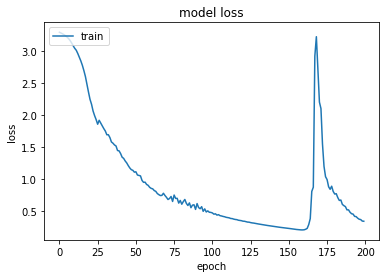

In [10]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### 예측 수행

In [9]:
def inference_embed(data) :
    inputs = to_char_array(data)
    output = tokenizer.texts_to_sequences([inputs])
    output = pad_sequences(output, maxlen=MAX_SEQUENCE_LENGTH)
    output = np_utils.to_categorical(output, MAX_NB_WORDS)
    return output

def predict(data):
    x_predict = inference_embed(data)
    y = model.predict(x_predict, verbose=0)
    arr = []
    for dim in y[0]:
        arr.append(dim.argmax())
    index_word = {v: k for k, v in tokenizer.word_index.items()}  # map back
    words = []
    for seq in arr:
        if(seq == 0):
            words.append('')
        else:
            words.append(index_word.get(seq))
    output_text = ''.join(words)
    print('input text :' + data)
    print('output text :' + output_text)  # output
    # print(mecab.morphs(output_text))

predict('치즈 피자 주문')
predict('메뉴 선택')
predict('음료 무엇')

input text :치즈 피자 주문
output text :치즈피자로주문되었습니다
input text :메뉴 선택
output text :메뉴를선택해주세요
input text :음료 무엇
output text :음료는무엇으로
